In [15]:
# Enable autoreload extension to automatically reload modules
%load_ext autoreload
%autoreload 1

# Import necessary modules and libraries
import AirSeaFluxCode  # Import AirSeaFluxCode class from AirSeaFluxCode module
import xarray as xr  # Import xarray library with alias xr
import gsw_xarray as gsw  # Import gsw_xarray module with alias gsw
import matplotlib.dates as mdates  # Import module for working with dates in matplotlib
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import numpy as np  # Import numpy library with alias np for numerical operations
import cartopy.crs as ccrs  # Import cartopy for geospatial data visualization
import cmocean.cm as cmo  # Import colormaps from cmocean for oceanography
from matplotlib.lines import Line2D
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.path as mpath
import cartopy.feature as cfeature
import string

from tqdm.notebook import tqdm_notebook as tqdm
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

RuntimeWarning
# Import my_funcs module for interactive reloading
%aimport my_funcs

# Call update_params function from my_funcs module to update parameters
my_funcs.update_params(fontsize=30)

# Define a function to customize x-axis ticks on a plot
def fix_xticks(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to display month
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # Format major ticks as abbreviated month (e.g., Jan)
    # Set x-axis label to '2019'
    ax.set_xlabel('2019')

# Define color variables with hexadecimal color codes
c20 = "#C13F89"  # Define color c20
c22 = "#3ec177"  # Define color c22
c23 = "#3e88c1"  # Define color c23
ext = "#a43ec1"  # Define color ext
c22 = "#00B4D8"  # Define color c22
c23 = "#0077B6"  # Define color c23

colors = [c20, c22, c23]
labels = ["1020", "1022", "1023"]


# Manually create Line2D objects for legend handles
legend_handles = [
    Line2D([], [], color=c20, lw=3, label='SD1020'),
    Line2D([], [], color=c22, lw=3, label='SD1022'),
    Line2D([], [], color=c23, lw=3, label='SD1023')
]

def km_formatter(x, pos):
    return f'{x / 1000:.0f} km'

def white_or_black(color):
    
    c1 = "white" if color == "white" else "black"
    c2 = "black" if color == "white" else "white"
    
    plt.rcParams.update({
        'figure.facecolor': c1,  # Background color of the figure
        'axes.facecolor': c1,    # Background color inside the plot area
        'savefig.facecolor': c1, # Background color when saving the figure
        'axes.edgecolor': c2,    # Color of the axes border
        'axes.labelcolor': c2,   # Color of the axis labels
        'xtick.color': c2,       # Color of the x-tick labels
        'ytick.color': c2,       # Color of the y-tick labels
        'text.color': c2,        # Default text color
        'axes.titlecolor': c2,   # Color of the plot title
        'font.size': 24,              # Size of the font
    })

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ds20 = xr.open_dataset("../data/ds20qc_1min_height.nc")
ds22 = xr.open_dataset("../data/ds22qc_1min_height.nc")
ds23 = xr.open_dataset("../data/ds23qc_1min_height.nc")
datasets = [ds20, ds22, ds23]

In [5]:
from matplotlib.colors import LinearSegmentedColormap
def get_cmap(half=False):
    """
    Create and return a custom colormap for visualizations.

    This function generates a linear segmented colormap that transitions through a specified 
    set of colors, ordered from dark red to dark blue. The colormap is defined using 
    hexadecimal color codes and is intended for use in visualizations where a smooth 
    transition between these colors is desired.

    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        A custom colormap object that can be used in plotting functions to map data values 
        to colors.

    Notes
    -----
    - The colormap transitions through the following colors (in reverse order for the final colormap):
      '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
      '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'.
    - The resulting colormap can be applied to any data visualization that supports colormaps, 
      such as those created with matplotlib.
    
    Example
    -------
    >>> cmap = get_cmap()
    >>> plt.imshow(data, cmap=cmap)
    >>> plt.colorbar()
    """
    
    # Define the colors in the order you've specified
    if half:
        colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7']
    else:
        colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
        
    # Create a colormap that transitions from the first color to the last
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])
    return cmap

cmap_half = get_cmap(half = True)
cmap = get_cmap(half = False)

## Temporal autocorrelation

In [10]:
def calc_and_plot_acv(ds, var, tw):
    """
    Function to calculate and plot autocorrelation values.

    Parameters:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        ds (xarray.Dataset): The dataset containing the variable data.
        var (str): The variable to calculate autocorrelation for.
        tw (int): The time window size for autocorrelation calculation.
        c (str): Color of the plotted lines.

    Returns:
        list: List of autocorrelation values calculated.
    """

    # Extract data for the variable from the dataset
    x = ds[var].values
    acf = []
    dists = []
    ssts = []
    winds = []
    
    # Calculate autocorrelations
    for i in range(int(len(x) / tw)):
        # if np.sum(~np.isfinite(x[tw*i: tw*(i+1) + 1])) > 60:
        #     print(i)
        
        #     continue
        # Calculate autocorrelation for the current time window
        ac = sm.tsa.acf(x[tw*i: tw*(i+1) + 1], nlags=tw, missing='conservative')
        dist  = np.cumsum(np.insert((gsw.distance(ds["longitude"][tw*i: tw*(i+1) + 1],ds["latitude"][tw*i: tw*(i+1) + 1])),0,0))
        # Plot autocorrelation values on the provided axes
        #ax.plot(ac, c=c, alpha=0.05, zorder=2)

        # Append autocorrelation values to the list
        acf.append(ac)
        dists.append(dist)
        ssts.append(ds["TEMP_CTD_RBR_MEAN"].values[tw*i: tw*(i+1) + 1])
        winds.append(ds["u10"].values[tw*i: tw*(i+1) + 1])

            
    return acf, dists, ssts, winds

In [12]:
def plot_acf_panels(ds):
    
    variables = ['u10', 't2m', 'TEMP_CTD_RBR_MEAN', 'sensible']

    # Loop through variables to calculate and plot autocorrelation
    acf = []
    dist = []
    sst = []
    wind = []
    for var in variables:
        acfs, dists, ssts, winds = calc_and_plot_acv(ds, var, 1440*2)
        acf.append(acfs)
        dist.append(dists)
        sst.append(ssts)
        wind.append(winds)
        
    return acf,dist,sst,winds

In [14]:
acf20, dist20, sst20, winds20 = plot_acf_panels(ds20)
acf22, dist22, sst22, winds22 = plot_acf_panels(ds22)
acf23, dist23, sst23, winds23 = plot_acf_panels(ds23)

In [16]:
def find_zero_crossings(acf):
    # Initialize arrays to store zero-crossing indices for each variable
    wind_fc = np.zeros(len(acf[0]), dtype=int)
    airt_fc = np.zeros(len(acf[0]), dtype=int)
    sst_fc = np.zeros(len(acf[0]), dtype=int)
    sens_fc = np.zeros(len(acf[0]), dtype=int)

    # Iterate over each sample
    for i in range(len(acf[0])):
        # Find the first index where autocorrelation crosses zero for each variable
        wind_fc[i] = np.argmax(acf[0][i] < 0)
        airt_fc[i] = np.argmax(acf[1][i] < 0)
        sst_fc[i] = np.argmax(acf[2][i] < 0)
        sens_fc[i] = np.argmax(acf[3][i] < 0)

    return wind_fc, airt_fc, sst_fc, sens_fc

# Usage
wind20_fc, airt20_fc, sst20_fc, sens20_fc = find_zero_crossings(acf20)
wind22_fc, airt22_fc, sst22_fc, sens22_fc = find_zero_crossings(acf22)
wind23_fc, airt23_fc, sst23_fc, sens23_fc = find_zero_crossings(acf23)

In [17]:
def calculate_integrals(acf, distances, wind_fc, airt_fc, sst_fc, sens_fc, winds):
    # Initialize arrays to hold integral results for each variable
    wind_integral = np.zeros(len(acf[0])) * np.nan
    airt_integral = np.zeros(len(acf[0])) * np.nan
    sst_integral = np.zeros(len(acf[0])) * np.nan
    sens_integral = np.zeros(len(acf[0])) * np.nan

    for i in tqdm(range(len(acf[0]))):
        if np.sum(~np.isfinite(winds[i])) < 200:
            
            # Integrate using the trapezoidal rule up to the first zero-crossing for each variable
            wind_integral[i] = np.trapz(acf[0][i][:wind_fc[i]], distances[0][i][:wind_fc[i]])*2
            airt_integral[i] = np.trapz(acf[1][i][:airt_fc[i]], distances[0][i][:airt_fc[i]])*2
            sst_integral[i] = np.trapz(acf[2][i][:sst_fc[i]], distances[0][i][:sst_fc[i]])*2
            sens_integral[i] = np.trapz(acf[3][i][:sens_fc[i]], distances[0][i][:sens_fc[i]])*2

    return wind_integral, airt_integral, sst_integral, sens_integral

# Usage
# Assuming 'acf20', 'distances20', etc., and zero-crossing indices like 'wind20_fc' are defined
wind20_integral, airt20_integral, sst20_integral, sens20_integral = calculate_integrals(acf20, dist20, wind20_fc, airt20_fc, sst20_fc, sens20_fc, winds20)
wind22_integral, airt22_integral, sst22_integral, sens22_integral = calculate_integrals(acf22, dist22, wind22_fc, airt22_fc, sst22_fc, sens22_fc, winds22)
wind23_integral, airt23_integral, sst23_integral, sens23_integral = calculate_integrals(acf23, dist23, wind23_fc, airt23_fc, sst23_fc, sens23_fc, winds23)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [18]:
def calculate_integrals_over_time(acf, wind_fc, airt_fc, sst_fc, sens_fc, winds):
    # Initialize arrays to hold integral results for each variable
    wind_integral = np.zeros(len(acf[0])) * np.nan
    airt_integral = np.zeros(len(acf[0])) * np.nan
    sst_integral = np.zeros(len(acf[0])) * np.nan
    sens_integral = np.zeros(len(acf[0])) * np.nan

    for i in tqdm(range(len(acf[0]))):
        if np.sum(~np.isfinite(winds[i])) < 200:
            # Integrate the ACF curve using indices as the time axis (1 index = 1 minute)
            time_axis = np.arange(len(acf[0][i]))  # Create a time axis in minutes
            
            # Integrate using the trapezoidal rule up to the first zero-crossing for each variable
            wind_integral[i] = np.trapz(acf[0][i][:wind_fc[i]], time_axis[:wind_fc[i]]) * 2 / 60
            airt_integral[i] = np.trapz(acf[1][i][:airt_fc[i]], time_axis[:airt_fc[i]]) * 2 / 60
            sst_integral[i] = np.trapz(acf[2][i][:sst_fc[i]], time_axis[:sst_fc[i]]) * 2 / 60
            sens_integral[i] = np.trapz(acf[3][i][:sens_fc[i]], time_axis[:sens_fc[i]]) * 2 / 60

    return wind_integral, airt_integral, sst_integral, sens_integral

# Usage
# Assuming 'acf20', 'wind20_fc', etc., are defined
wind20_tintegral, airt20_tintegral, sst20_tintegral, sens20_tintegral = calculate_integrals_over_time(acf20, wind20_fc, airt20_fc, sst20_fc, sens20_fc, winds20)
wind22_tintegral, airt22_tintegral, sst22_tintegral, sens22_tintegral = calculate_integrals_over_time(acf22, wind22_fc, airt22_fc, sst22_fc, sens22_fc, winds22)
wind23_tintegral, airt23_tintegral, sst23_tintegral, sens23_tintegral = calculate_integrals_over_time(acf23, wind23_fc, airt23_fc, sst23_fc, sens23_fc, winds23)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [19]:
def calculate_efolding_scale(acf_ds, dists_ds):
    
    wind_efold = np.zeros(len(dists_ds[0]))*np.nan
    airt_efold = np.zeros(len(dists_ds[1]))*np.nan
    sst_efold = np.zeros(len(dists_ds[2]))*np.nan
    sens_efold = np.zeros(len(dists_ds[3]))*np.nan

    for acfs,dists,efold in zip(acf_ds, dists_ds,[wind_efold,airt_efold,sst_efold,sens_efold]):
        for i,(acf,dist) in enumerate(zip(acfs,dists)):
            
            efold[i] = (dist[np.argmax(acf < 1 / np.e)])
            
    return wind_efold,airt_efold,sst_efold,sens_efold

In [20]:
wind20_efold, airt20_efold, sst20_efold, sens20_efold = calculate_efolding_scale(acf20, dist20)
wind22_efold, airt22_efold, sst22_efold, sens22_efold = calculate_efolding_scale(acf22, dist22)
wind23_efold, airt23_efold, sst23_efold, sens23_efold = calculate_efolding_scale(acf23, dist23)

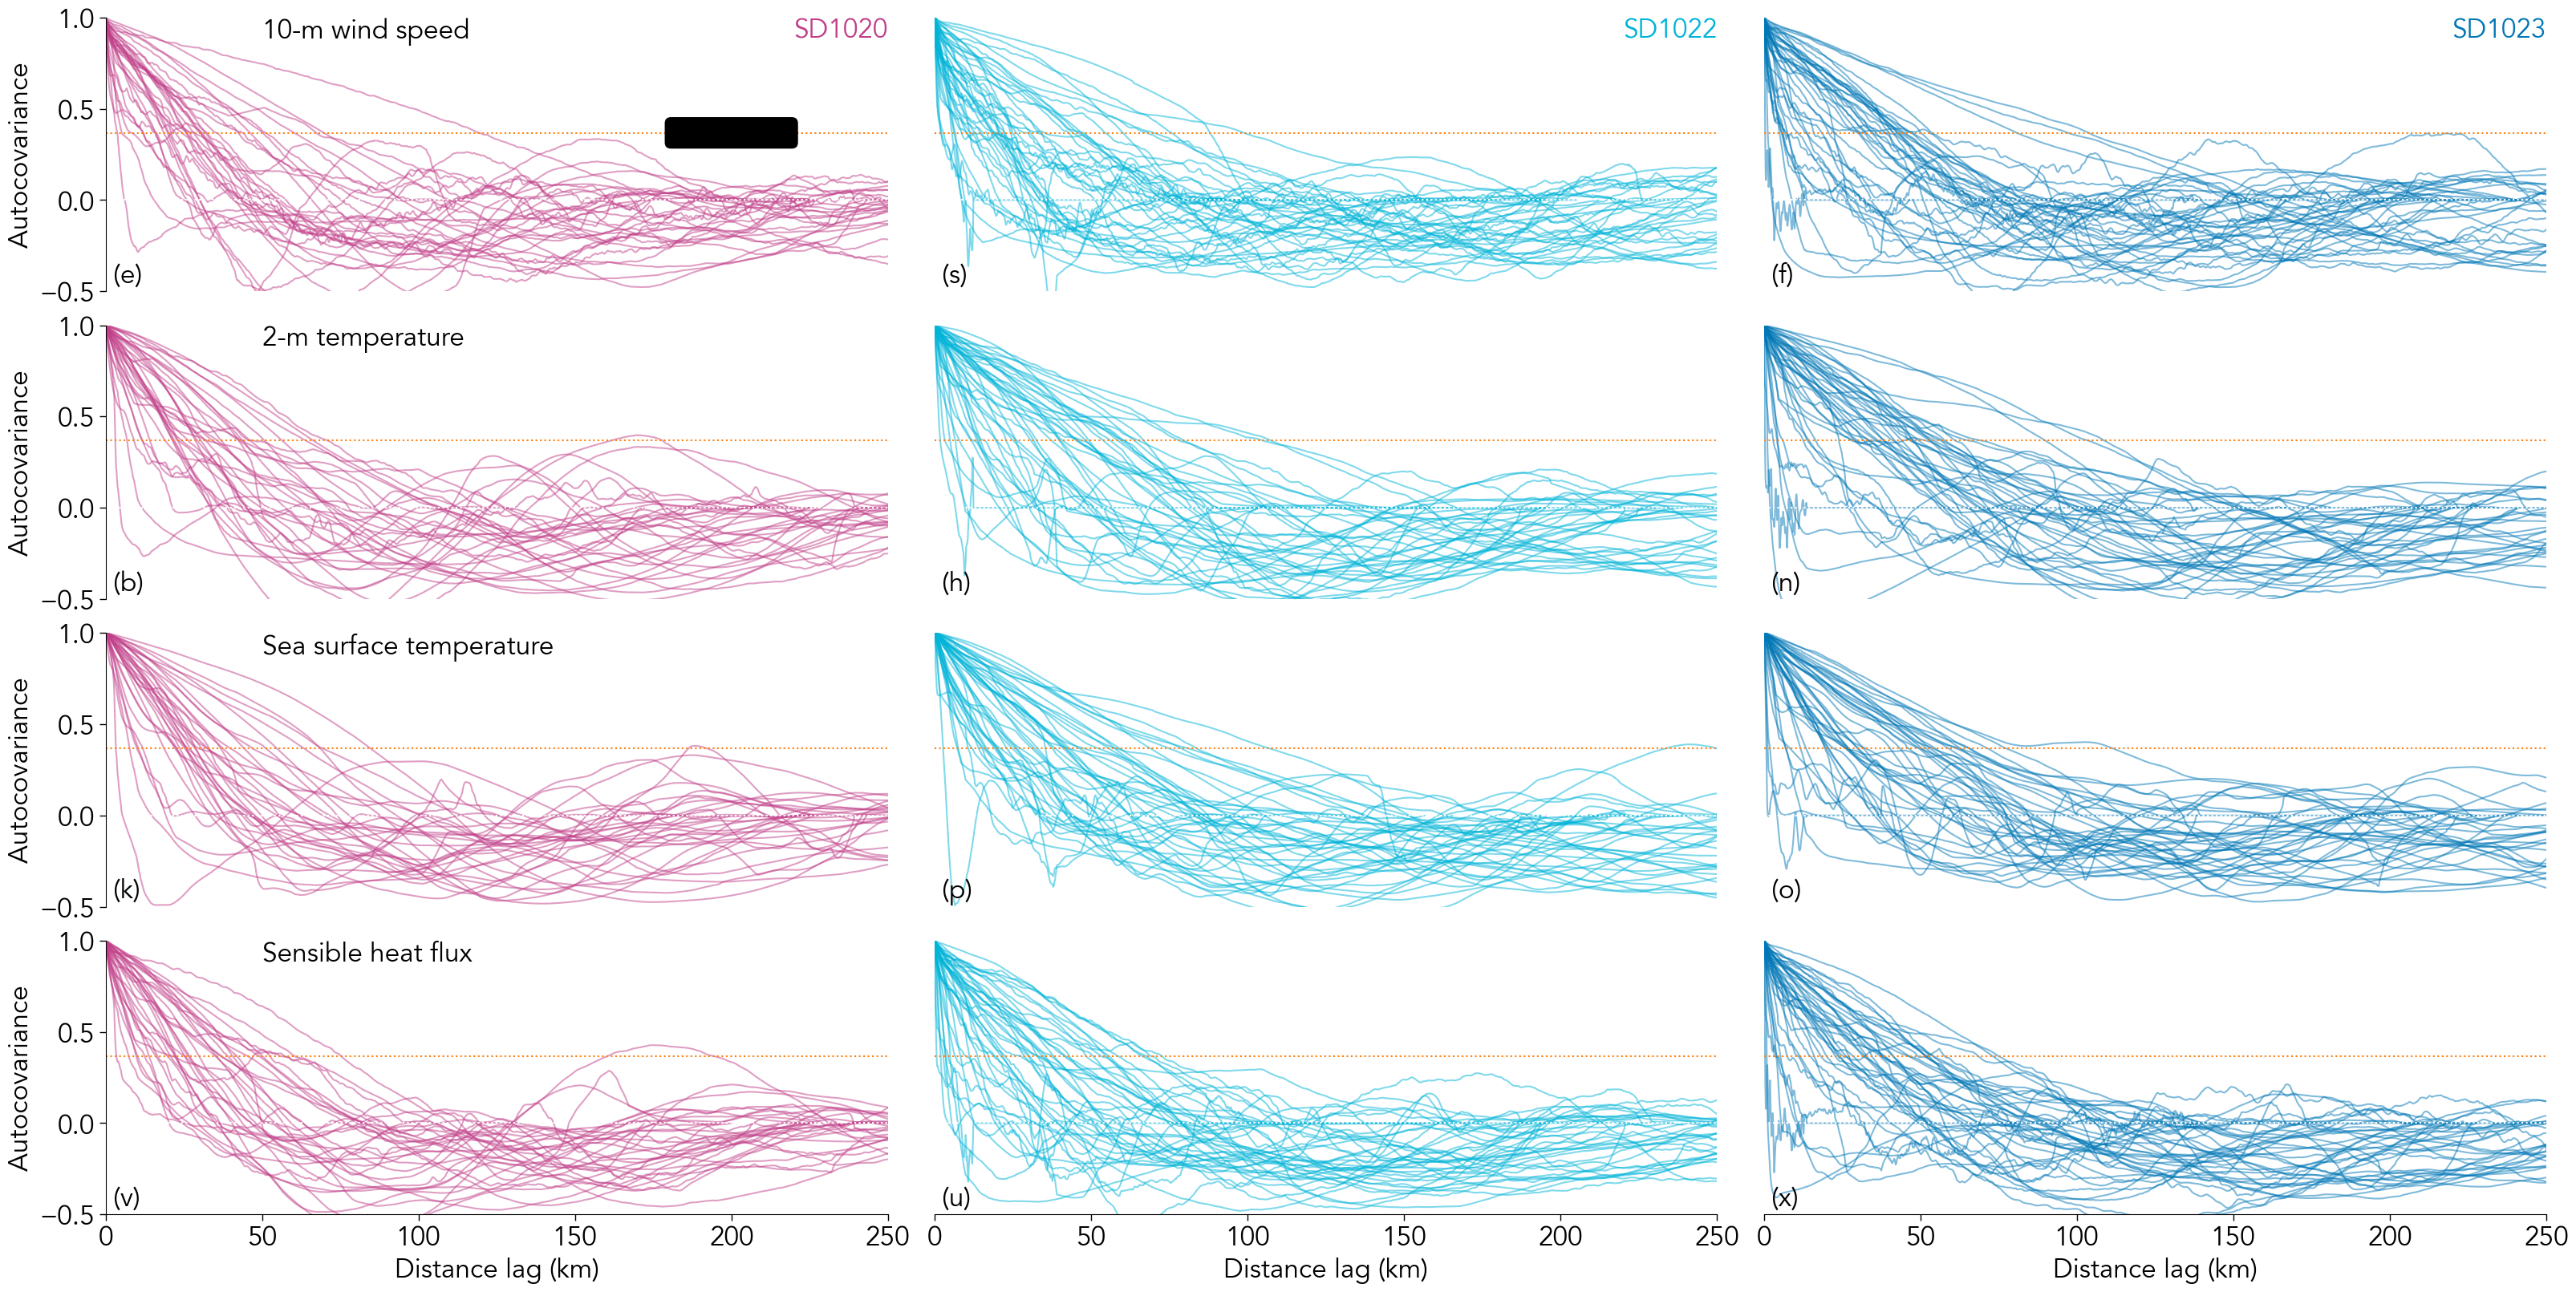

In [34]:
fig,ax = plt.subplots(4,3,figsize=(32,16),constrained_layout=True, sharex=True, sharey=True)



names = ["10-m wind speed", "2-m temperature", "Sea surface temperature", "Sensible heat flux"]
drones = ["SD1020","SD1022","SD1023"]


for j,(AX,acfds,distds,drone,c) in enumerate(zip(ax.T,acf_ds,dist_ds,drones,colors)):
    for i,(axs,acfs,dists,name) in enumerate(zip(AX,acfds,distds,names)):
        for acf,dist in zip(acfs,dists):
            axs.plot(dist/1000,acf,c=c,alpha=0.5)
    
        axs.axhline(1/np.e,ls=":",c="C1")    
        axs.axhline(0,ls=":",c="w")    
        # axs.axvline(0,ls=":",c="w")
        axs.set(ylabel="Autocovariance",xlim=(0,250),ylim=(-0.5,1))
        if j == 0:
            axs.text(50,1,name,ha="left",va="top")
            if i == 0:
                axs.text(200,1/np.e,"e-folding scale",va="center",ha="center",fontsize="x-small",
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="k"))
        if i == 0:
            axs.text(250,1,drone,ha="right",va="top",c=c,fontweight="bold")
        axs.spines['top'].set_visible(False)
        axs.spines['right'].set_visible(False)
        if i < 3:
            axs.spines['bottom'].set_visible(False)
            axs.xaxis.set_visible(False)
        if j > 0:
            axs.spines['left'].set_visible(False)
            axs.yaxis.set_visible(False)
    
    axs.set(xlabel="Distance lag (km)")


letters = list(string.ascii_lowercase)
np.random.shuffle(letters)

for axs, l in zip(ax.T.flatten(),letters):
    axs.text(0,-0.49,f" ({l})",ha="left",va="bottom")

In [21]:
def calculate_means(*arrays):
    for array in arrays:
        mean = ((np.nanmedian(array))).round(1)
    return mean

def calculate_stds(*arrays):
    for array in arrays:
        mean = ((np.nanstd(array))).round(1)
    return mean

In [22]:
import pandas as pd

# Create a dictionary with the mean values
data = {
    'SD1020': [calculate_means(wind20_efold), calculate_means(airt20_efold), calculate_means(sst20_efold), calculate_means(sens20_efold)],
    'SD1022': [calculate_means(wind22_efold), calculate_means(airt22_efold), calculate_means(sst22_efold), calculate_means(sens22_efold)],
    'SD1023': [calculate_means(wind23_efold), calculate_means(airt23_efold), calculate_means(sst23_efold), calculate_means(sens23_efold)]
}

# Create a DataFrame
df = pd.DataFrame(data, index=['Median Wind',
                               'Median Air Temperature',
                               'Median Sea Surface Temperature',
                               'Median Sensible Heat Flux'])

In [23]:
df

SD1020   SD1022   SD1023
Median Wind                     26801.5  21648.8  31506.8
Median Air Temperature          30498.4  38648.8  37546.2
Median Sea Surface Temperature  28823.4  32471.3  30048.9
Median Sensible Heat Flux       26484.0  29356.9  30146.1

In [24]:
import pandas as pd

# Create a dictionary with the mean values
data = {
    'SD1020': [calculate_means(wind20_integral)/1000, calculate_means(airt20_integral)/1000, calculate_means(sst20_integral)/1000, calculate_means(sens20_integral)/1000],
    'SD1022': [calculate_means(wind22_integral)/1000, calculate_means(airt22_integral)/1000, calculate_means(sst22_integral)/1000, calculate_means(sens22_integral)/1000],
    'SD1023': [calculate_means(wind23_integral)/1000, calculate_means(airt23_integral)/1000, calculate_means(sst23_integral)/1000, calculate_means(sens23_integral)/1000]
}

# Create a DataFrame
df = pd.DataFrame(data, index=['Median Wind',
                               'Median Air Temperature',
                               'Median Sea Surface Temperature',
                               'Median Sensible Heat Flux'])

In [25]:
df.mean(axis=0)

SD1020    46.484375
SD1022    51.645400
SD1023    59.416600
dtype: float64

In [81]:
import pandas as pd

# Create a dictionary with the mean values
data = {
    'SD1020': [calculate_means(wind20_tintegral), calculate_means(airt20_tintegral), calculate_means(sst20_tintegral), calculate_means(sens20_tintegral)],
    'SD1022': [calculate_means(wind22_tintegral), calculate_means(airt22_tintegral), calculate_means(sst22_tintegral), calculate_means(sens22_tintegral)],
    'SD1023': [calculate_means(wind23_tintegral), calculate_means(airt23_tintegral), calculate_means(sst23_tintegral), calculate_means(sens23_tintegral)]
}

# Create a DataFrame
dft = pd.DataFrame(data, index=['Median Wind',
                               'Median Air Temperature',
                               'Median Sea Surface Temperature',
                               'Median Sensible Heat Flux'])

print(dft)
#print(np.mean(dft,axis=1))

import pandas as pd

# Create a dictionary with the mean values
data = {
    'SD1020': [calculate_stds(wind20_tintegral), calculate_stds(airt20_tintegral), calculate_stds(sst20_tintegral), calculate_stds(sens20_tintegral)],
    'SD1022': [calculate_stds(wind22_tintegral), calculate_stds(airt22_tintegral), calculate_stds(sst22_tintegral), calculate_stds(sens22_tintegral)],
    'SD1023': [calculate_stds(wind23_tintegral), calculate_stds(airt23_tintegral), calculate_stds(sst23_tintegral), calculate_stds(sens23_tintegral)]
}

# Create a DataFrame
dft = pd.DataFrame(data, index=['Median Wind',
                               'Median Air Temperature',
                               'Median Sea Surface Temperature',
                               'Median Sensible Heat Flux'])

print(dft)

print(np.mean(dft,axis=1))

                                SD1020  SD1022  SD1023
Median Wind                        7.8     8.1     8.6
Median Air Temperature             8.7    10.0    10.9
Median Sea Surface Temperature     8.3    10.0    10.3
Median Sensible Heat Flux          8.1     8.5     9.3
                                SD1020  SD1022  SD1023
Median Wind                        3.4     3.3     3.1
Median Air Temperature             3.5     3.0     3.2
Median Sea Surface Temperature     3.1     3.7     3.7
Median Sensible Heat Flux          3.4     2.7     2.8
Median Wind                       3.266667
Median Air Temperature            3.233333
Median Sea Surface Temperature    3.500000
Median Sensible Heat Flux         2.966667
dtype: float64


In [26]:
import pandas as pd

# Create a dictionary with the mean values
data = {
    'SD1020': [calculate_stds(wind20_tintegral), calculate_stds(airt20_tintegral), calculate_stds(sst20_tintegral), calculate_stds(sens20_tintegral)],
    'SD1022': [calculate_stds(wind22_tintegral), calculate_stds(airt22_tintegral), calculate_stds(sst22_tintegral), calculate_stds(sens22_tintegral)],
    'SD1023': [calculate_stds(wind23_tintegral), calculate_stds(airt23_tintegral), calculate_stds(sst23_tintegral), calculate_stds(sens23_tintegral)]
}

# Create a DataFrame
dft = pd.DataFrame(data, index=['Median Wind',
                               'Median Air Temperature',
                               'Median Sea Surface Temperature',
                               'Median Sensible Heat Flux'])

In [27]:
# Function to remove NaN values from datasets
def remove_nans(datasets):
    return [np.array(data)[~np.isnan(data)] for data in datasets]

# Define the datasets and remove NaN values
datasets_20 = remove_nans([wind20_efold, airt20_efold, sst20_efold, sens20_efold])
datasets_22 = remove_nans([wind22_efold, airt22_efold, sst22_efold, sens22_efold])
datasets_23 = remove_nans([wind23_efold, airt23_efold, sst23_efold, sens23_efold])

# Define the datasets and remove NaN values
datasets_20 = remove_nans([wind20_integral, airt20_integral, sst20_integral, sens20_integral])
datasets_22 = remove_nans([wind22_integral, airt22_integral, sst22_integral, sens22_integral])
datasets_23 = remove_nans([wind23_integral, airt23_integral, sst23_integral, sens23_integral])

# Define the datasets and remove NaN values
datasets_20t = remove_nans([wind20_tintegral, airt20_tintegral, sst20_tintegral, sens20_tintegral])
datasets_22t = remove_nans([wind22_tintegral, airt22_tintegral, sst22_tintegral, sens22_tintegral])
datasets_23t = remove_nans([wind23_tintegral, airt23_tintegral, sst23_tintegral, sens23_tintegral])


In [28]:
datasets = [datasets_20, datasets_22, datasets_23]
tdatasets = [datasets_20t, datasets_22t, datasets_23t]
labels = ["SD1020","SD1022","SD1023"]

In [29]:
# List of datasets and colors
acf_ds = [acf20, acf22, acf23]
dist_ds = [dist20, dist22, dist23]
colors = [c20, c22, c23]

# Assuming all datasets have the same shape (e.g., same number of columns)
n_cols = int(len(acf_ds[0]))

## Figure 6

In [35]:
fig, axs = plt.subplots(2, 4, figsize=(20, 12), constrained_layout=True, sharey="row", dpi=600)

paper = True

if paper:
    white_or_black("white")
    color = "k"
else:
    white_or_black("black")
    color = "w"

variables = ["u10", "t2m", "TEMP_CTD_RBR_MEAN", "sensible"]
names = ["10-m wind speed", "2-m air temperature", "Sea surface temperature", "Sensible heat flux"]
units = ["m s$^{-1}$", "°C", "°C", "W m$^{-2}$"]
ylims = [[0, 25], [-5, 20], [-5, 20], [-300, 100]]

# Plot function for top row (ACF and distance)
def plot_acf_dist(ax, acf, dist, color, name, label):
    mean_dist, mean_acf = np.nanmean(dist, axis=0) / 1000, np.nanmean(acf, axis=0)
    ax.plot(mean_dist, mean_acf, c=color, lw=3, zorder=3,label=label)
    ax.plot(mean_dist, mean_acf - np.nanstd(acf, axis=0), c=color, alpha=1, zorder=2, lw=1, ls="--")
    ax.plot(mean_dist, mean_acf + np.nanstd(acf, axis=0), c=color, alpha=1, zorder=2, lw=1, ls="--")
    ax.axhline(0, c="k", lw=1, ls="--", zorder=1)
    ax.set(xlim=(0, 300),
           ylim=(-0.5, 1),
           ylabel="Autocorrelation" if j == 0 else "")
    ax.set_title(name)
    ax.set_xlabel("Distance lag (km)",labelpad=10)
    ax.set_xticks(np.arange(0,301,100))
    ax.set_xticks(np.arange(0,301,50),minor=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.grid(ls=":",axis="both",which="major")
    if ("wind" in name):
        ax.legend(loc="upper right", frameon=False, fontsize="small")
    
# Plot function for bottom row (violin plots)
def plot_violin(ax, da, i, c):
    vplot = ax.violinplot(da/1000, positions=[[1020,1022,1023][i]], showextrema=False, widths=0.75)
    quartile1, medians, quartile3 = np.nanpercentile(da/1000, [25, 50, 75], axis=0)
    ax.scatter([[1020,1022,1023][i]], medians, marker='o', color='w', s=30, zorder=5)
    ax.vlines([[1020,1022,1023][i]], quartile1, quartile3, color='k', linestyle='-', lw=5, zorder=4)
    #ax.axhline(50,lw=3,ls="--",c="w",zorder=1)
    for body in vplot['bodies']:
        body.set_facecolor(c)
        body.set_edgecolor(color)
        body.set_zorder(3)
        body.set_alpha(1)
    

# Loop over datasets and plot
for i, (acfs, dists, ds, c, label) in enumerate(zip(acf_ds, dist_ds, datasets, colors, labels)):
    for j,(ax, acf, dist, name) in enumerate(zip(axs[0], acfs, dists, names)):
        # if i == 0:
        #     ax.axhline(1/np.e,c="C1",lw=2,ls="--")

        # if j == 0:
        #     ax.text(150,1/np.e,"e-folding scale",va="center",ha="center",fontsize="x-small",
        #             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="k"))
        plot_acf_dist(ax, acf, dist, c, name, label)  # Top row

    for j, (ax, da) in enumerate(zip(axs[1], ds)):
        plot_violin(ax, da, i, c)  # Bottom row
        if  j==0:  
            ax.text([1020,1022,1023][i],np.max(da/1000)+5,f"n={len(da)}",ha="center")

# Customize bottom row
for i, (ax, name, unit, ylim) in enumerate(zip(axs[1], names, units, ylims)):
    ax.set(xlim=(1019, 1024),
           ylim=(0, 200),
           yticks=np.arange(0, 201, 50))
    ax.set_xticks([1020, 1022, 1023],labels=labels,rotation=45)
    ax.spines['bottom'].set_bounds(1019, 1024)
    ax.spines['left'].set_bounds(0, 200)
    # ax.spines['left'].set_position(('outward', 10))
    # ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['bottom'].set_visible(True)
    ax.yaxis.set_major_formatter('{x:1.0f} km')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i == 0:    
        ax.set_ylabel("Decorrelation length scale",y=100/200)

axs = axs.flatten()
for ax, l in zip(axs,string.ascii_lowercase):
    ax.text(0.02,0.02,f"({l})",ha="left", va="bottom", transform=ax.transAxes)

plt.savefig("../figures/decorrelation_plot.png",dpi=600)

## Figure S2

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 12), constrained_layout=True, sharey="row", dpi=600)

paper = True

if paper:
    white_or_black("white")
    color = "k"
else:
    white_or_black("black")
    color = "w"

variables = ["u10", "t2m", "TEMP_CTD_RBR_MEAN", "sensible"]
names = ["10-m wind speed", "2-m air temperature", "Sea surface temperature", "Sensible heat flux"]
units = ["m s$^{-1}$", "°C", "°C", "W m$^{-2}$"]
ylims = [[0, 25], [-5, 20], [-5, 20], [-300, 100]]

# Plot function for top row (ACF and distance)
def plot_acf_dist(ax, acf, color, name, label):
    mean_acf = np.nanmean(acf, axis=0)
    ax.plot(np.arange(len(mean_acf))/60, mean_acf, c=color, lw=3, zorder=3,label=label)
    ax.plot(np.arange(len(mean_acf))/60, mean_acf - np.nanstd(acf, axis=0), c=color, alpha=1, zorder=2, lw=1, ls="--")
    ax.plot(np.arange(len(mean_acf))/60, mean_acf + np.nanstd(acf, axis=0), c=color, alpha=1, zorder=2, lw=1, ls="--")
    ax.axhline(0, c="k", lw=1, ls="--", zorder=1)
    ax.set(xlim=(0, 48),
           ylim=(-0.5, 1),
           xticks=np.arange(0,49,12),
           ylabel="Autocorrelation" if j == 0 else "")
    ax.set_title(name)
    ax.set_xlabel("Time lag (h)",labelpad=10)
    #ax.set_xticks(np.arange(0,301,100))
    #ax.set_xticks(np.arange(0,301,50),minor=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if ("wind" in name):
        ax.legend(loc="upper right", frameon=False, fontsize="small")
    
# Plot function for bottom row (violin plots)
def plot_violin(ax, da, i, c):
    vplot = ax.violinplot(da, positions=[[1020,1022,1023][i]], showextrema=False, widths=0.75)
    quartile1, medians, quartile3 = np.nanpercentile(da, [25, 50, 75], axis=0)
    ax.scatter([[1020,1022,1023][i]], medians, marker='o', color='w', s=30, zorder=5)
    ax.vlines([[1020,1022,1023][i]], quartile1, quartile3, color='k', linestyle='-', lw=5, zorder=4)
    #ax.axhline(50,lw=3,ls="--",c="w",zorder=1)
    for body in vplot['bodies']:
        body.set_facecolor(c)
        body.set_edgecolor(color)
        body.set_zorder(3)
        body.set_alpha(1)
    

# Loop over datasets and plot
for i, (acfs, ds, c, label) in enumerate(zip(acf_ds, tdatasets, colors, labels)):
    for j,(ax, acf, name) in enumerate(zip(axs[0], acfs, names)):
        # if i == 0:
        #     ax.axhline(1/np.e,c="C1",lw=2,ls="--")

        # if j == 0:
        #     ax.text(150,1/np.e,"e-folding scale",va="center",ha="center",fontsize="x-small",
        #             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="k"))
        plot_acf_dist(ax, acf, c, name, label)  # Top row

    for j, (ax, da) in enumerate(zip(axs[1], ds)):
        plot_violin(ax, da, i, c)  # Bottom row
        if  j==0:  
            ax.text([1020,1022,1023][i],np.max(da)+1,f"n={len(da)}",ha="center")

# Customize bottom row
for i, (ax, name, unit, ylim) in enumerate(zip(axs[1], names, units, ylims)):
    ax.set(xlim=(1019, 1024),
           ylim=(0, 18),
           yticks=np.arange(0, 19, 6))
    ax.set_xticks([1020, 1022, 1023],labels=labels,rotation=45)
    ax.spines['bottom'].set_bounds(1019, 1024)
    #ax.spines['left'].set_bounds(0, 200)
    # ax.spines['left'].set_position(('outward', 10))
    # ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['bottom'].set_visible(True)
    ax.yaxis.set_major_formatter('{x:1.0f}h')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # if i == 0:    
    #     ax.set_ylabel("Decorrelation length scale",y=100/200)
    # ax.grid(ls=":",axis="y")

axs = axs.flatten()
for ax, l in zip(axs,string.ascii_lowercase):
    ax.text(0.02,0.02,f"({l})",ha="left", va="bottom", transform=ax.transAxes)

plt.savefig("../figures/temp_decorrelation_plot.png",dpi=600)